<a href="https://colab.research.google.com/github/Machine-Learning-Tokyo/KaggleDaysTokyo2019/blob/master/kaggleDays_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Links

APTOS: https://www.kaggle.com/c/aptos2019-blindness-detection

EfficientNet: https://pypi.org/project/efficientnet/

CLR: https://github.com/bckenstler/CLR

RAdam: https://pypi.org/project/keras-radam/

AccumOptimizer: https://github.com/bojone/accum_optimizer_for_keras

lr_multiplier: https://pypi.org/project/keras-lr-multiplier/

### Mount google drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Install and authenticate kaggle API

In [0]:
# %%capture
## Get kaggle.json from Google Drive

# !pip install --upgrade pip
# !pip install -U -q kaggle
# !mkdir -p .kaggle
# !mkdir -p ~/.kaggle

# !cp /content/drive/'My Drive'/kaggle_blindness/kaggle.json ~/.kaggle/kaggle.json
# !kaggle config set -n path -v{/content}
# !chmod 600 /root/.kaggle/kaggle.json

In [0]:
%%capture
## Alternatively

!pip install --upgrade pip
!pip install -U -q kaggle
!mkdir -p .kaggle
!mkdir -p ~/.kaggle

import json
token = {"username":"your name","key":"your key"} # use your username & key here (kaggle API token)
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json

### Download and unzip the data

In [0]:
DATA_DIR = '/kaggle/input/aptos2019-blindness-detection/'

In [3]:
!mkdir -p $DATA_DIR && cd $DATA_DIR && \
kaggle competitions download -c aptos2019-blindness-detection -p $DATA_DIR && \
unzip -q train_images.zip -d ./train_images && rm train_images.zip && \
unzip -q test_images.zip -d ./test_images && rm test_images.zip

100% 8.01G/8.01G [02:01<00:00, 69.5MB/s]
100% 8.01G/8.01G [02:01<00:00, 70.8MB/s]
 99% 1.48G/1.50G [00:17<00:00, 73.3MB/s]
100% 1.50G/1.50G [00:17<00:00, 90.1MB/s]
  0% 0.00/53.7k [00:00<?, ?B/s]
100% 53.7k/53.7k [00:00<00:00, 48.5MB/s]
  0% 0.00/24.5k [00:00<?, ?B/s]
100% 24.5k/24.5k [00:00<00:00, 22.1MB/s]
  0% 0.00/28.3k [00:00<?, ?B/s]
100% 28.3k/28.3k [00:00<00:00, 27.7MB/s]


In [0]:
import tensorflow as tf
import keras
tf.__version__, keras.__version__

('1.15.0', '2.2.5')

In [0]:
!ls $DATA_DIR
!ls $DATA_DIR/train_images | head
!head $DATA_DIR/train.csv

sample_submission.csv  test.csv  test_images  train.csv  train_images
000c1434d8d7.png
001639a390f0.png
0024cdab0c1e.png
002c21358ce6.png
005b95c28852.png
0083ee8054ee.png
0097f532ac9f.png
00a8624548a9.png
00b74780d31d.png
00cb6555d108.png
id_code,diagnosis
000c1434d8d7,2
001639a390f0,4
0024cdab0c1e,1
002c21358ce6,0
005b95c28852,0
0083ee8054ee,4
0097f532ac9f,0
00a8624548a9,2
00b74780d31d,2


In [0]:
!pip install -q efficientnet
!git clone https://github.com/bckenstler/CLR.git
!pip install -q keras-radam
!git clone https://github.com/bojone/accum_optimizer_for_keras.git
!pip install -q keras-lr-multiplier

In [0]:
# imports

import numpy as np
import pandas as pd
import random
from random import choice
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
import cv2
import albumentations as A

import efficientnet.keras as efn
from CLR.clr_callback import CyclicLR
from keras_radam import RAdam
from accum_optimizer_for_keras.accum_optimizer import AccumOptimizer
from keras_lr_multiplier import LRMultiplier

import keras
from keras.preprocessing.image import ImageDataGenerator

In [0]:
# parameters

train_ratio = 0.85
img_size = 512

batch_size = 4
steps_per_update = 16

## Dataframes

In [0]:
train_df = pd.read_csv(f'{DATA_DIR}train.csv')
train_df.id_code = train_df.id_code.astype(str) + '.png'

train_index = int(len(train_df) * train_ratio)
val_df = train_df[train_index:]
train_df = train_df[:train_index]
val_df.reset_index(drop=True, inplace=True)

val_df.head()

,id_code,diagnosis
0,d85ea1220a03.png,4
1,d865997a6280.png,0
2,d866c26d76f0.png,0
3,d868acdccb5b.png,3
4,d871895742b1.png,0


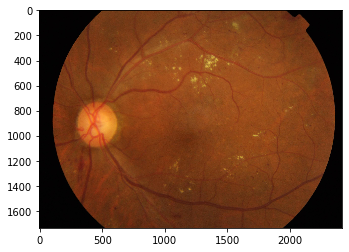

In [0]:
img_name = f'{DATA_DIR}/train_images/{choice(val_df.id_code)}'
img = plt.imread(img_name)
plt.imshow(img)
plt.show()

## Data generators

In [0]:
train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True,
                                   zoom_range=(0.8, 1.2), rescale=1/255.)
val_datagen = ImageDataGenerator(rescale=1/255.)

train_gen = train_datagen.flow_from_dataframe(train_df, f'{DATA_DIR}train_images',
                                              x_col='id_code', y_col='diagnosis', batch_size=batch_size,
                                              target_size=(img_size, img_size), class_mode='raw', shuffle=True)
val_gen = val_datagen.flow_from_dataframe(val_df, f'{DATA_DIR}train_images',
                                          x_col='id_code', y_col='diagnosis', batch_size=batch_size,
                                          target_size=(img_size, img_size), class_mode='raw', shuffle=False)

Found 3112 validated image filenames.
Found 550 validated image filenames.


In [0]:
def crop_image(img, tol=0.1):
    tol = tol * np.max(img)
    mask = img[..., 0] > tol
    return img[np.ix_(mask.any(1),mask.any(0))]

    
class DataGenerator(keras.utils.Sequence):
    def __init__(self, df, imgs_dir=f'{DATA_DIR}train_images/', batch_size=batch_size, img_size=img_size, mode='train'):
        self.df = df
        self.imgs_dir = imgs_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.mode = mode
        print(f'Found {len(df)} items')
    
    def __len__(self):
        return np.ceil(len(self.df) / self.batch_size).astype(int)

    def augment(self, img):
        augmentation = A.Compose([
                                  A.HorizontalFlip(),
                                  A.VerticalFlip(),
                                  A.Rotate(360),
                                  A.RandomBrightnessContrast(),
                                  A.RandomScale(),
                                  A.Resize(self.img_size, self.img_size)
        ])
        img = augmentation(image=img)['image']
        return img

    def get_imgs(self, tmp_df):
        imgs = []
        for img_name in tmp_df.id_code:
            img = cv2.imread(f'{self.imgs_dir}{img_name}')
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = crop_image(img)
            img = cv2.resize(img, (self.img_size, self.img_size))
            if self.mode == 'train':
                img = self.augment(img)
            img = img / 255.
            imgs.append(img)
        return np.array(imgs)

    def __getitem__(self, index):
        tmp_df = self.df.iloc[index * self.batch_size: (index+1) * self.batch_size]
        imgs = self.get_imgs(tmp_df)
        labels = tmp_df.diagnosis.values
        return imgs, labels

train_gen = DataGenerator(train_df)
val_gen = DataGenerator(val_df, mode='val')

Found 3112 items
Found 550 items


2


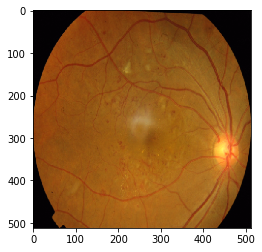

In [0]:
imgs, labels = choice(train_gen)
img, label = imgs[0], labels[0]
print(label)
plt.imshow(img)
plt.show()

## Model (training)

In [0]:
# architecture
keras.backend.clear_session()
base_model = efn.EfficientNetB3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
input = base_model.input
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(5, activation='relu')(x)
output = keras.layers.Dense(1)(x)
model = keras.Model(input, output)

# compile
optimizer = AccumOptimizer(RAdam(), steps_per_update=steps_per_update)
multipliers = {f'block{i}': (i/10) + .2 for i in range(1, 8)}
multipliers.update({'stem': .1})
optimizer = LRMultiplier(optimizer, multipliers)
loss = 'mse'
metrics = ['mae']
model.compile(optimizer, loss, metrics)

# callbacks
earlystopping = keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=5, restore_best_weights=True)
lr_plateau = keras.callbacks.ReduceLROnPlateau(monitor='val_mean_absolute_error', patience=3)
clr = CyclicLR(base_lr=5e-5, max_lr=5e-3,
               step_size=len(train_gen)*2, mode='triangular2')

# train
model.fit_generator(train_gen, epochs=20, validation_data=val_gen, workers=4,
                    callbacks=[
                               earlystopping,
                            #    lr_plateau,
                               clr,
                               ])

In [0]:
keras.backend.clear_session()
model = keras.models.load_model('/content/drive/My Drive/kaggle_blindness/model_0/best_model_qwk_0.9017.h5')

# Model (evaluation)

In [0]:
predictions = model.predict_generator(val_gen, verbose=1, workers=8).reshape(-1)
predictions = np.round(predictions).clip(0, 4).astype(int)
real_values = val_df.diagnosis.values
qwk = cohen_kappa_score(predictions, real_values, weights='quadratic')
qwk

138/138 [==============================] - 47s 344ms/step


0.9017374603599982